### Предсказание наличия аллергенов в городе по сообщениям пользователей группы VK

В рамках проекта обрабатываются сообщения пользователей из группы VK. На основании сообщений выделяются топонимы и классифицируются сообщения. Сообщения классифицируются как сообщение о факте наличия или отсутсвия аллергии у пользователя. На основе классификатора готовим карту городов, где пользователи сообщали о наличии аллергии. 

In [43]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug  7 15:39:51 2022

@author: 72090
"""
#imports
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_df = pd.read_csv('DB/train.csv', index_col = 0, sep = ';', encoding='utf-8-sig', on_bad_lines='skip')
test_df = pd.read_csv('DB/test.csv', index_col = 0, sep = ';', encoding='utf-8-sig', on_bad_lines='skip')

X = train_df.drop(['date', 'user','target'], axis = 1)
y = train_df['target']
X = X.fillna('other')

X_test = test_df.drop(['date', 'user', 'target'], axis = 1)
y_test = test_df['target']
X_test = X_test.fillna('other') 

cat_features = ['city', 'moscow_district', 'region', 'area']
numeric_features = ['site', 'allergens', 'medicins', 'symptom', 'negative', 'positive']
text_features = ['msg']
scaler = StandardScaler()
scaler.fit(X[numeric_features])
X[numeric_features] = scaler.transform(X[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

train_data = Pool(X, label = y, cat_features=cat_features, text_features = text_features)
test_data = Pool(X_test, label = y_test, cat_features=cat_features, text_features = text_features)

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

model_ct =  CatBoostClassifier(verbose = 3,
                               eval_metric='AUC',
                               max_depth=8,
                               learning_rate = 0.1,
                               class_weights = weights,
                               early_stopping_rounds=100)
model_ct.fit(train_data, plot = True, use_best_model = True, eval_set = test_data)
print("F1_Score", f1_score(y_test, model_ct.predict(X_test)))
print("F1_Score на константной модели", f1_score(y_test, pd.Series([1]*len(y_test))))
print("precision_score", precision_score(y_test, model_ct.predict(X_test)))
print("recall_score", recall_score(y_test, model_ct.predict(X_test)))
print("ROC_AUC_SCORE", roc_auc_score(y_test, model_ct.predict_proba(X_test)[:, 1]))
model_ct.save_model('model/cat_model_vs_text')
print('Обучение закончено, модель сохранена.')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8454687	best: 0.8454687 (0)	total: 293ms	remaining: 4m 52s
3:	test: 0.8485417	best: 0.8485417 (3)	total: 1.25s	remaining: 5m 11s
6:	test: 0.8734896	best: 0.8805208 (5)	total: 2.22s	remaining: 5m 14s
9:	test: 0.8803125	best: 0.8886979 (8)	total: 3.51s	remaining: 5m 47s
12:	test: 0.8766146	best: 0.8886979 (8)	total: 4.61s	remaining: 5m 49s
15:	test: 0.8796875	best: 0.8886979 (8)	total: 5.73s	remaining: 5m 52s
18:	test: 0.8855729	best: 0.8886979 (8)	total: 6.75s	remaining: 5m 48s
21:	test: 0.8877604	best: 0.8895312 (19)	total: 7.69s	remaining: 5m 42s
24:	test: 0.8872396	best: 0.8895312 (19)	total: 8.63s	remaining: 5m 36s
27:	test: 0.8902604	best: 0.8909896 (26)	total: 9.52s	remaining: 5m 30s
30:	test: 0.8966146	best: 0.8966146 (30)	total: 10.5s	remaining: 5m 26s
33:	test: 0.8951562	best: 0.8966146 (30)	total: 11.4s	remaining: 5m 24s
36:	test: 0.8973958	best: 0.8973958 (36)	total: 12.6s	remaining: 5m 26s
39:	test: 0.8973437	best: 0.8973958 (36)	total: 13.6s	remaining: 5m 25s
42:

Модель обучна. Её recall_score равенн 0.7916666666666666 (мы находим примерно 79 процентов правильных ответов).

Максимизируем точность предсказание модели. Для этого найдем оптимальное значение вероятности, выше которого мы будем говорить, что факт аллергии найден. 

Построим ROC_AUC кривую для наглядности.

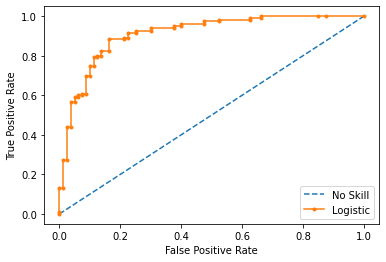

In [53]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model_ct.predict_proba(X_test)[:, 1]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, trh = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Наилучшее значение вероятности (trh) получется в точке наиболее близкой к левому верхнему углу графика. Найде это значение.

In [55]:
diff = 0
tpr = None
fpr = None
best_trh = None

for i in range(len(lr_fpr)):
    
    if diff < lr_tpr[i] - lr_fpr[i]:
        diff = lr_tpr[i] - lr_fpr[i]
        tpr = lr_tpr[i]
        fpr = lr_fpr[i]
        best_trh = trh[i]
        
print(f"Минимально расстояние {diff} достигается при значении tpr = {tpr} и fpr = {fpr}, лучший trh - {best_trh}")


Минимально расстояние 0.7208333333333333 достигается при значении tpr = 0.8833333333333333 и fpr = 0.1625, лучший trh - 0.3411492842925379


Посчитаем качество предсказаний модели.

In [57]:
print("Best F1_Score", f1_score(y_test, (model_ct.predict_proba(X_test)[:, 1] > 0.3411492842925379)*1))
print("Best precision_score", precision_score(y_test, (model_ct.predict_proba(X_test)[:, 1] > 0.3411492842925379)*1))
print("Best recall_score", recall_score(y_test, (model_ct.predict_proba(X_test)[:, 1] > 0.3411492842925379)*1))

Best F1_Score 0.8823529411764707
Best precision_score 0.8898305084745762
Best recall_score 0.875


Качество повысилось. Best recall_score 0.875 (мы находим примерно 87 процентов правильных ответов)

Подготовим новое предсказание с учетом найденной вероятности.

In [58]:
X_rest = pd.read_csv('DB/rest.csv', index_col = 0, sep = ';', encoding='utf-8-sig', on_bad_lines='skip')

X_rest = X_rest.drop(['date', 'user'], axis = 1)
X_rest = X_rest.fillna('other')

cat_features = ['city', 'moscow_district', 'region', 'area']
numeric_features = ['site', 'allergens', 'medicins', 'symptom', 'negative', 'positive']
text_features = ['msg']

model = CatBoostClassifier()

prediction = model.load_model('model/cat_model_vs_text', format='cbm').predict_proba(X_rest)

X_rest['predict'] = pd.Series((prediction[:, 1]> 0.3411492842925379)*1)


Загрузим базу городов

In [74]:
cities  = pd.read_csv('DB/cities_utf_sig.csv', index_col = 0, sep = ';', encoding='utf-8-sig', on_bad_lines='skip')

Подготовим список аллергенов.

In [88]:
from work_func import file_to_list
from yargy import rule, Parser, or_
from yargy.pipelines import morph_pipeline
from yargy.interpretation import fact
allergen_list = set(file_to_list('text/allergen.txt', separator = '\n'))
#загружаем список мест проявления аллергии

#объявим факт - Allergen - аллерген
Allergen = fact(
    'Allergen',
    ['name']
)

#морф пайплайн для аллергенов
ALLERGEN_PIPELINE = morph_pipeline(
    allergen_list
).interpretation(
    Allergen.name.normalized().custom(lambda x: x.title())
)

ALLERGEN_RULE = rule(
    ALLERGEN_PIPELINE
).interpretation(
    Allergen
)

parser = Parser(ALLERGEN_RULE)
X_rest['allerg'] = X_rest['msg'].apply(lambda x: ' '.join([match.fact.name for match in parser.findall(x)]))
print('Allergens done!')

Allergens done!


Подготовим список найденных городов с географическими координатами и списком аалергенов.

In [89]:
city_geo = []
for i in range(len(cities['city'])):
    for j in range(len(X_rest['city'])):
        if (X_rest['predict'][j] == 1) and (X_rest['city'][j] == cities['city'][i]):
            city_geo.append([cities['city'][i], cities['geo_lat'][i], cities['geo_lon'][i], X_rest['allerg'][j]])
            break
print("Готово")

Готово


Превратим список в DataFrame для удобства работы.

In [93]:
city = pd.DataFrame(city_geo, columns = ['city', 'geo_lat', 'geo_lon', 'allergens'])
city

,city,geo_lat,geo_lon,allergens
0,Барнаул,53.347997,83.779806,
1,Бийск,52.539386,85.213845,
2,Свободный,51.361410,128.121973,Пыль Пыльца
3,Архангельск,64.539429,40.516961,
4,Мирный,62.764527,40.336008,
...,...,...,...,...
206,Зеленоград,55.982500,37.181390,Береза
207,Санкт-Петербург,59.939131,30.315900,Береза Полынь
208,Балашиха,55.809450,37.958060,
209,Мыс Фиолент,44.501336,33.489023,


Нарисуем график

In [102]:
import plotly
import plotly.graph_objs as go
fig = go.Figure(go.Scattermapbox(lat=city['geo_lat'], lon=city['geo_lon'], text=city['city'] + ' ' + city['allergens']))
map_center = go.layout.mapbox.Center(lat=(city['geo_lat'].max()+city['geo_lat'].min())/2, 
                                     lon=(city['geo_lon'].max()+city['geo_lon'].min())/2)
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=2))
fig.show()

### Вывод

Мы обучили модель. И сопоставили предсказания модели с географическими координатами городо. Затем отобразили результат на карте.  Итоговые метрики модели:

 - Best F1_Score 0.8823529411764707
 - Best precision_score 0.8898305084745762
 - Best recall_score 0.875

Модель предсказывает факт наличия у людей аллергии в 87,5 процентах случаев. На основании предсказаний модели мы выводим карту с названиями городов и найденными аллергенами. К сожалению люди указывая на алергию не всегда указывают аллерген, поэтому в некоторых местах есть только название города, без списка аллергенов.

Модель можно дополнительно улучшить:
 - работа со спиками городов, округов, районов, областе, аллергенов, частей тела, лекарств, негативных и позитивных высказываний.
 - дополнительнаяя токенизация сообщений в рамках модели CatBoostClassifier с чисткой стоп слов

Возможна выгрузка сообщений прямо из группы с использованием библиотеки VK
Как интересная идея возможно будет лучше использовать телеграм бота, который будет по расписанию опрашивать людей про самочуствие и на основании опросов присылать прогнозы. Их точность и полнота вероятно могут быть лучше.